In [1]:
from utils import *

# Vectorization Solutions

In [2]:
import jax.numpy as jnp
import chex

## Array Operations

In [3]:
def array_operations_q1(N):
    return jnp.sum(jnp.log(jnp.arange(N) + 1.0))

print(array_operations_q1(10.0))
print(array_operations_q1(20.0))

15.104412
42.335617


In [4]:
def array_operations_q2(N, M):
    i = jnp.tile(jnp.arange(N)[..., None], M)
    j = jnp.tile(jnp.arange(M)[..., None], N).T

    return jnp.sum(jnp.log(i * j + 1.0))

print(array_operations_q2(5, 10))
print(array_operations_q2(30, 20))

84.905975
2507.8203


## Slicing

In [5]:
def array_slicing_q1(a):
    return a[1:] - a[:-1]

array_slicing_q1(jnp.array([0.0, 1.0, 5.0, 10.0, 20.0]))

Array([ 1.,  4.,  5., 10.], dtype=float32)

In [6]:
def array_slicing_q2(a):
    return a[..., 1:] - a[..., :-1]

array_slicing_q2(jnp.array([
    [0.0, 1.0, 5.0, 10.0, 20.0],
    [2.0, 5.0, 6.0, 20.0, 30.0]
]))

Array([[ 1.,  4.,  5., 10.],
       [ 3.,  1., 14., 10.]], dtype=float32)

## Indexing with Boolean Arrays

In [7]:
def boolean_indexing_q1(a):
    chex.assert_rank(a, 2)    
    positive_sum = a.sum(axis=-1) > 0.0
    return a[positive_sum]

boolean_indexing_q1(jnp.array([
    [1.0, 2.0, 3.0],
    [-1.0, -2.0, 3.0],
    [-1.0, -2.0, 4.0],
    [-1.0, -2.0, -3.0],
]))

Array([[ 1.,  2.,  3.],
       [-1., -2.,  4.]], dtype=float32)

In [8]:
def boolean_indexing_q2(N, x, y, r):
    assert(0 < N)
    assert(0 <= x and x < N)
    assert(0 <= y and y < N)
    assert(0 < r)
    
    rows = jnp.tile(jnp.arange(N)[..., None], N)
    cols = rows.T
    result = ((rows - x) ** 2.0 + (cols - y) ** 2.0 <= r ** 2.0).astype('int32')

    chex.assert_shape(result, (N, N))
    return result

print(boolean_indexing_q2(10, 3, 4, 2))
print('')
print(boolean_indexing_q2(10, 9, 8, 2))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]]


## Indexing with Arrays of Indices

In [9]:
def integer_indexing_q1(a):
    chex.assert_rank(a, 2)
    chex.assert_size(a, a.shape[0] ** 2)
    
    i = jnp.arange(a.shape[0])
    result = a[(i, i)]

    chex.assert_shape(result, (a.shape[0],))
    return result

a = jnp.arange(6 * 6).reshape(6, 6)
print(a)
print('')
print(integer_indexing_q1(a))

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]

[ 0  7 14 21 28 35]


In [10]:
def integer_indexing_q2(a, offset=0):
    chex.assert_rank(a, 2)
    chex.assert_size(a, a.shape[0] ** 2)
    
    i = jnp.arange(a.shape[0] - abs(offset)) - offset * (offset <= 0)
    j = jnp.arange(a.shape[1] - abs(offset)) + offset * (offset > 0)
    result = a[(i, j)]

    chex.assert_shape(result, (a.shape[0] - abs(offset),))
    return result

a = jnp.arange(6 * 6).reshape(6, 6)
print(a)
print('')

for offset in [-2, -1, 0, 1, 2]:
    print(f'Offset {offset}:', integer_indexing_q2(a, offset=offset))

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]

Offset -2: [12 19 26 33]
Offset -1: [ 6 13 20 27 34]
Offset 0: [ 0  7 14 21 28 35]
Offset 1: [ 1  8 15 22 29]
Offset 2: [ 2  9 16 23]


## Broadcasting

In [11]:
def broadcasting_q1(a, b):
    chex.assert_rank((a, b), 2)
    chex.assert_equal_shape_suffix((a, b), 1)
    
    result = jnp.sum((b[None, ...] - a[:, None, ...]) ** 2.0, axis=-1)

    chex.assert_shape(result, (a.shape[0], b.shape[0]))
    return result

a = jnp.array([
    [1, 2],
    [2, 4],
    [5, 6],
])

b = jnp.array([
    [5, 3],
    [4, 1],
    [6, 6],
    [7, 1],
])

broadcasting_q1(a, b)

Array([[17., 10., 41., 37.],
       [10., 13., 20., 34.],
       [ 9., 26.,  1., 29.]], dtype=float32)

## Regression Solutions

In [12]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax.numpy as jnp
import jax.random as jrandom
import numpyro
import numpyro.distributions as D
import numpyro.distributions.constraints as C
from cs349 import *

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-regression-augmented.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Glow,Telekinetic-Ability
Patient ID,,,
90,30.607729,0.604085,-0.020933
254,38.531357,0.613645,-0.070165
283,21.879414,0.829212,0.140791
445,2.949004,0.981120,0.261027
461,30.237446,0.688329,-0.027250
15,29.562483,0.796853,-0.033701
316,15.283975,0.839546,0.344510
489,2.688488,0.929422,0.268031
159,4.129371,0.893813,0.422464


In [13]:
def model_polynomial_regression(N, x, y=None, degree=1):
    coefficients = numpyro.param(
        'coefficients',
        jnp.ones(degree + 1),
        constraint=C.real,
    )

    std_dev = numpyro.param(
        'std_dev',
        jnp.array(1.0),
        constraint=C.positive,
    )

    with numpyro.plate('data', N):
        mu = jnp.polyval(coefficients, x)
        p_y_given_x = D.Normal(mu, std_dev)
        numpyro.sample('y', p_y_given_x, obs=y)

In [14]:
NUM_ITERATIONS = 10000
DEGREE = 2

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

result = cs349_mle(
    model_polynomial_regression, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    jnp.array(data['Glow']), 
    y=jnp.array(data['Telekinetic-Ability']),
    degree=DEGREE,
)

100%|█| 10000/10000 [00:01<00:00, 5823.25it/s, init loss: 1717.8445, avg. loss [9501-100


Done.


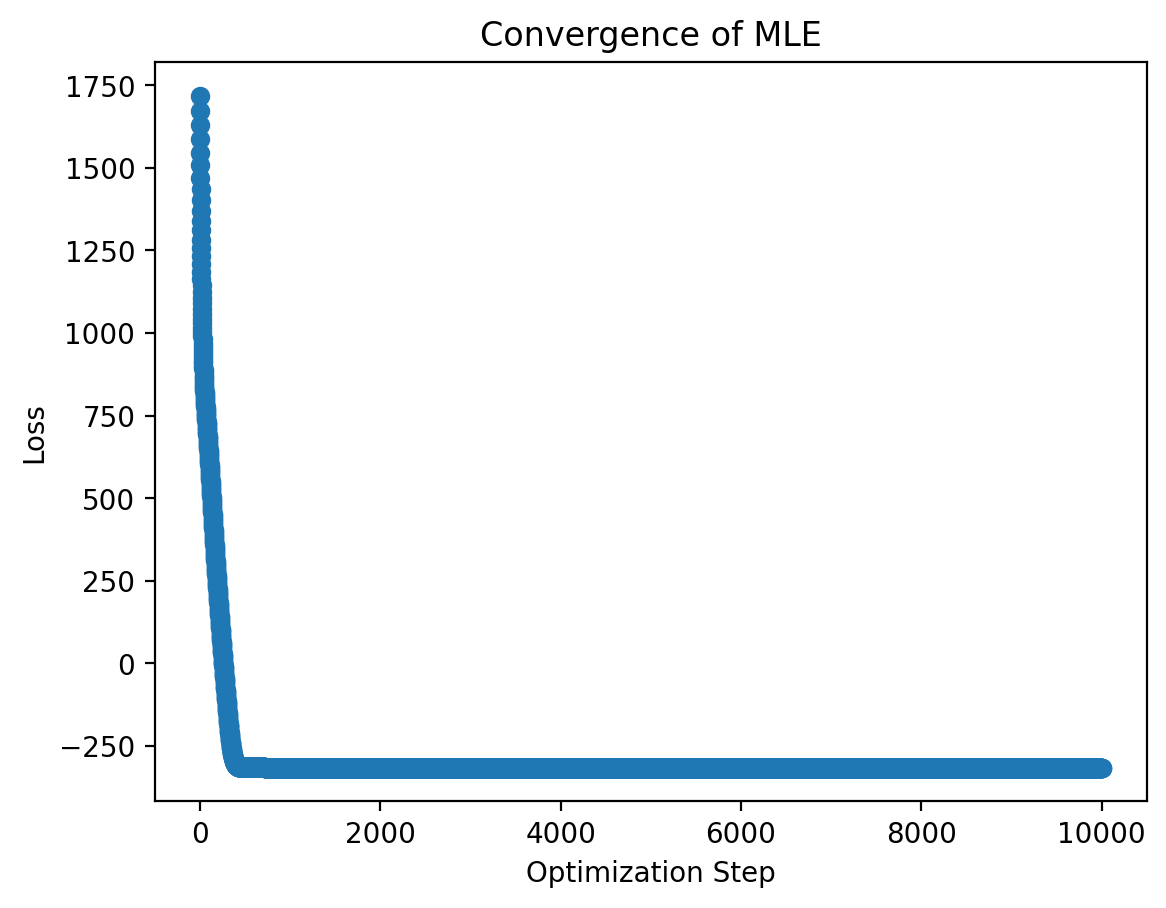

In [15]:
plt.scatter(jnp.arange(NUM_ITERATIONS), result.losses)
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.title('Convergence of MLE')
plt.show()

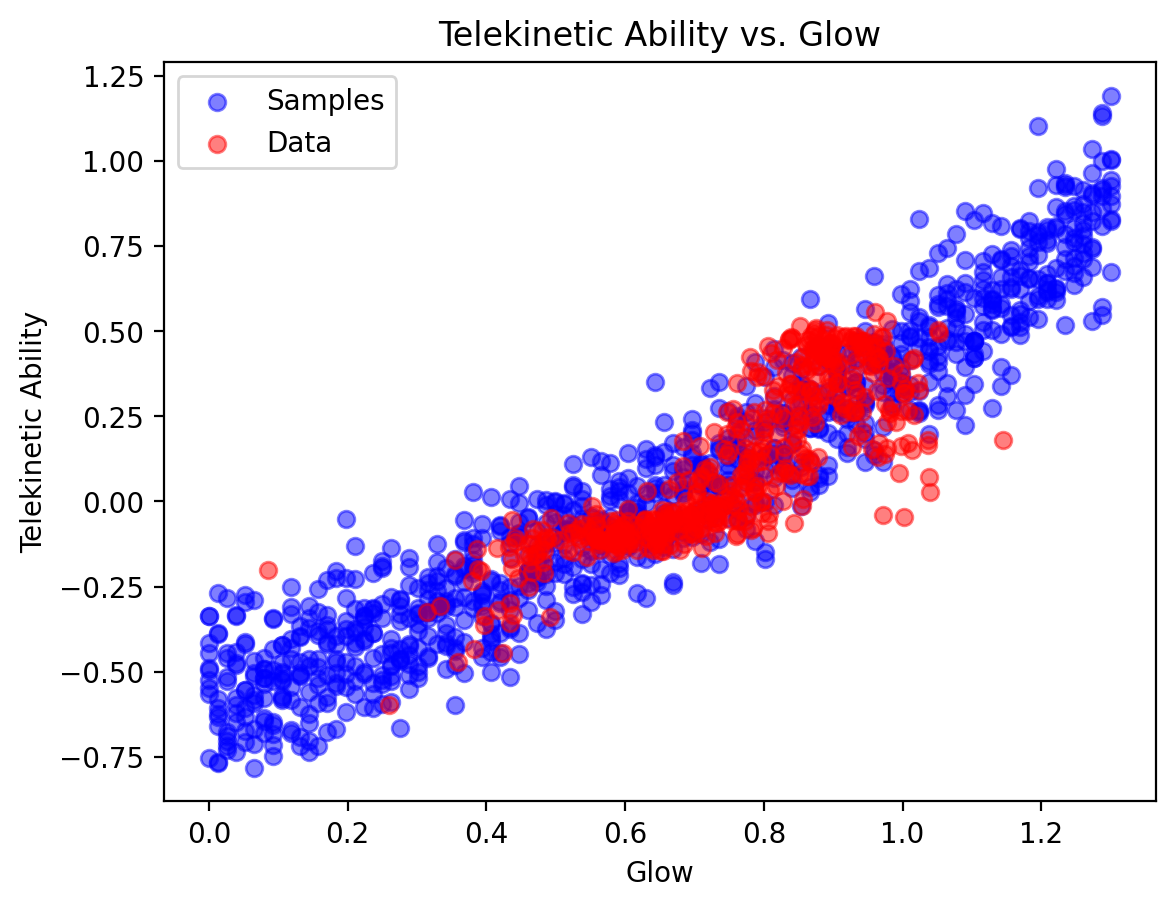

In [16]:
test_x = jnp.linspace(0.0, 1.3, 100)

S = 10
samples = cs349_sample_generative_process(
    result.model_mle, 
    jrandom.PRNGKey(seed=0), 
    len(test_x), 
    test_x,
    degree=DEGREE,
    num_samples=S,
)

plt.scatter(
    test_x[None, ...].repeat(S, axis=0).flatten(), 
    samples['y'].flatten(), 
    color='blue', 
    alpha=0.5,
    label='Samples',
)
plt.scatter(data['Glow'], data['Telekinetic-Ability'], color='red', alpha=0.5, label='Data')

plt.xlabel('Glow')
plt.ylabel('Telekinetic Ability')
plt.title('Telekinetic Ability vs. Glow')

plt.legend()
plt.show()

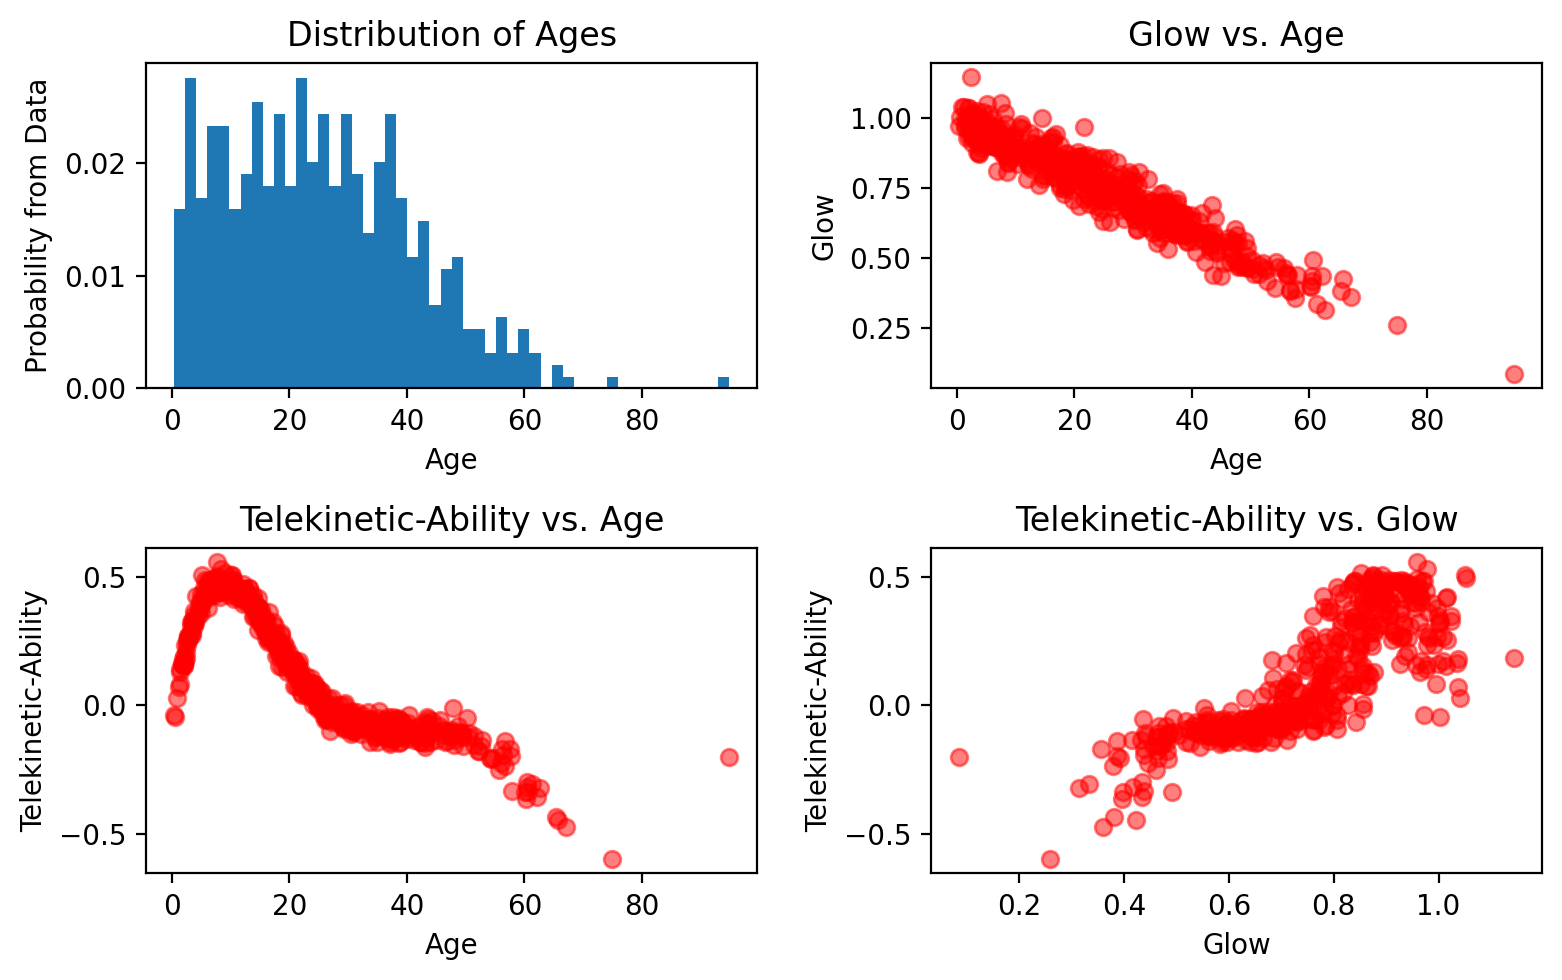

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(data['Age'], bins=50, density=True)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Probability from Data')
axes[0, 0].set_title('Distribution of Ages')

axes[0, 1].scatter(data['Age'], data['Glow'], alpha=0.5, color='red')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Glow')
axes[0, 1].set_title('Glow vs. Age')

axes[1, 0].scatter(data['Age'], data['Telekinetic-Ability'], alpha=0.5, color='red')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Telekinetic-Ability')
axes[1, 0].set_title('Telekinetic-Ability vs. Age')

axes[1, 1].scatter(data['Glow'], data['Telekinetic-Ability'], alpha=0.5, color='red')
axes[1, 1].set_xlabel('Glow')
axes[1, 1].set_ylabel('Telekinetic-Ability')
axes[1, 1].set_title('Telekinetic-Ability vs. Glow')

plt.tight_layout()
plt.show()

## Classification Solutions

In [18]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax.numpy as jnp
import jax.random as random
import jax.nn as jnn
import numpyro
import numpyro.distributions as D
import numpyro.distributions.constraints as C
from cs349 import *

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-classification.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Dose,Telekinetic-Control
Patient ID,,,
405,17.600859,0.764120,1
1190,5.332611,0.944742,1
1132,35.766937,0.796327,1
731,33.879105,0.802059,1
1754,26.795975,0.228325,1
1178,11.604771,0.185052,1
1533,3.343291,0.372828,1
1303,27.073309,0.497788,1
1857,77.514244,0.300860,0


In [56]:
def model_polynomial_classification(N, x, y=None, degree=1):
    coefficients_age = numpyro.param(
        'coefficients_age',
        jnp.ones(degree + 1) * 0.1,
        constraint=C.real,
    )

    coefficients_dose = numpyro.param(
        'coefficients_dose',
        jnp.ones(degree + 1) * 0.1,
        constraint=C.real,
    )

    with numpyro.plate('data', N):
        rho = jnn.sigmoid(
            jnp.polyval(coefficients_age, x[..., 0] / 100.0) 
            + jnp.polyval(coefficients_dose, x[..., 1])
        )
        p_y_given_x = D.Bernoulli(rho)
        numpyro.sample('y', p_y_given_x, obs=y)

In [60]:
NUM_ITERATIONS = 200000
DEGREE = 8

# Define an optimizer; here we chose the "Adam" algorithm
optimizer = numpyro.optim.Adam(step_size=0.01)

# Pick a random generator seed for the optimizer
key_optimizer = jrandom.PRNGKey(seed=0)

result = cs349_mle(
    model_polynomial_classification, 
    optimizer, 
    key_optimizer, 
    NUM_ITERATIONS,
    len(data), 
    jnp.array(data[['Age', 'Dose']]), 
    y=jnp.array(data['Telekinetic-Control']),
    degree=DEGREE,
)

100%|█| 200000/200000 [00:47<00:00, 4211.89it/s, init loss: 1216.2925, avg. loss [190001


Done.


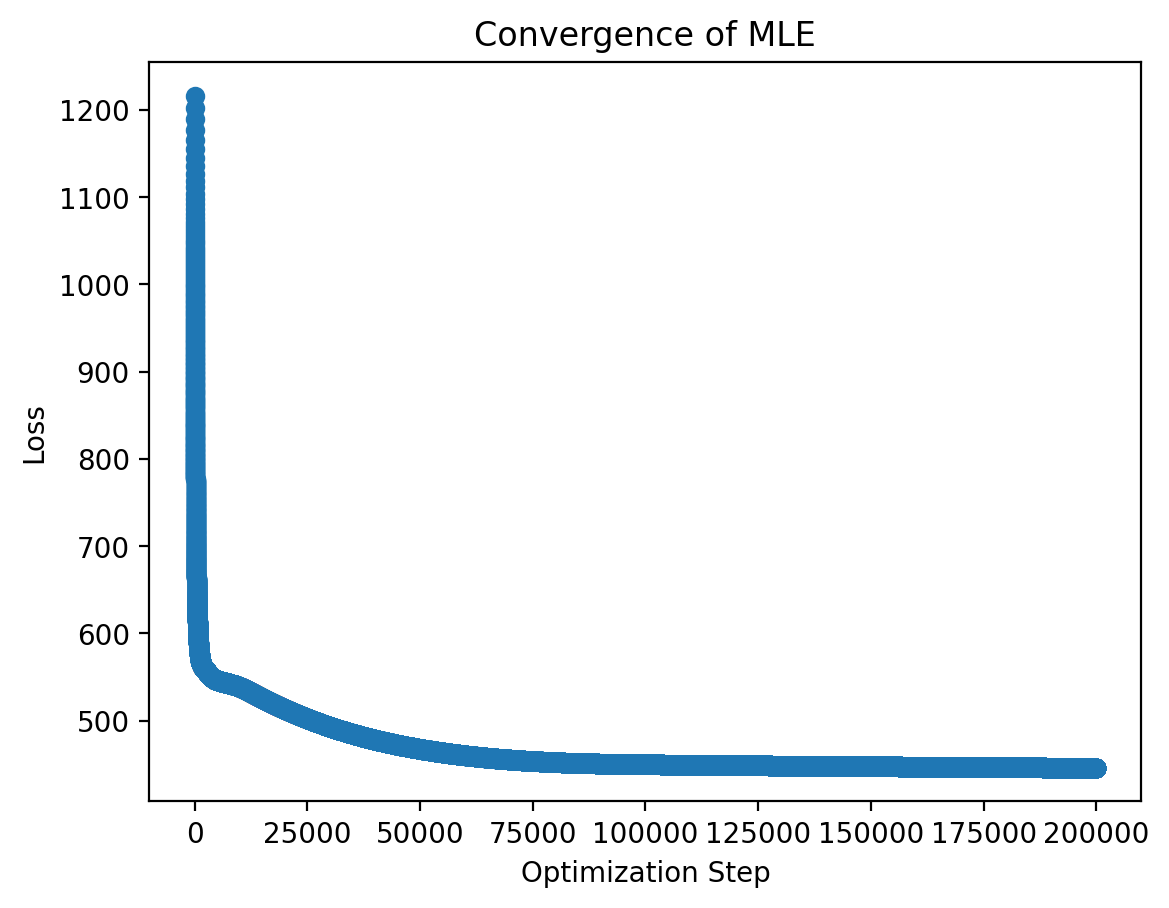

In [61]:
plt.scatter(jnp.arange(NUM_ITERATIONS), result.losses)
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.title('Convergence of MLE')
plt.show()

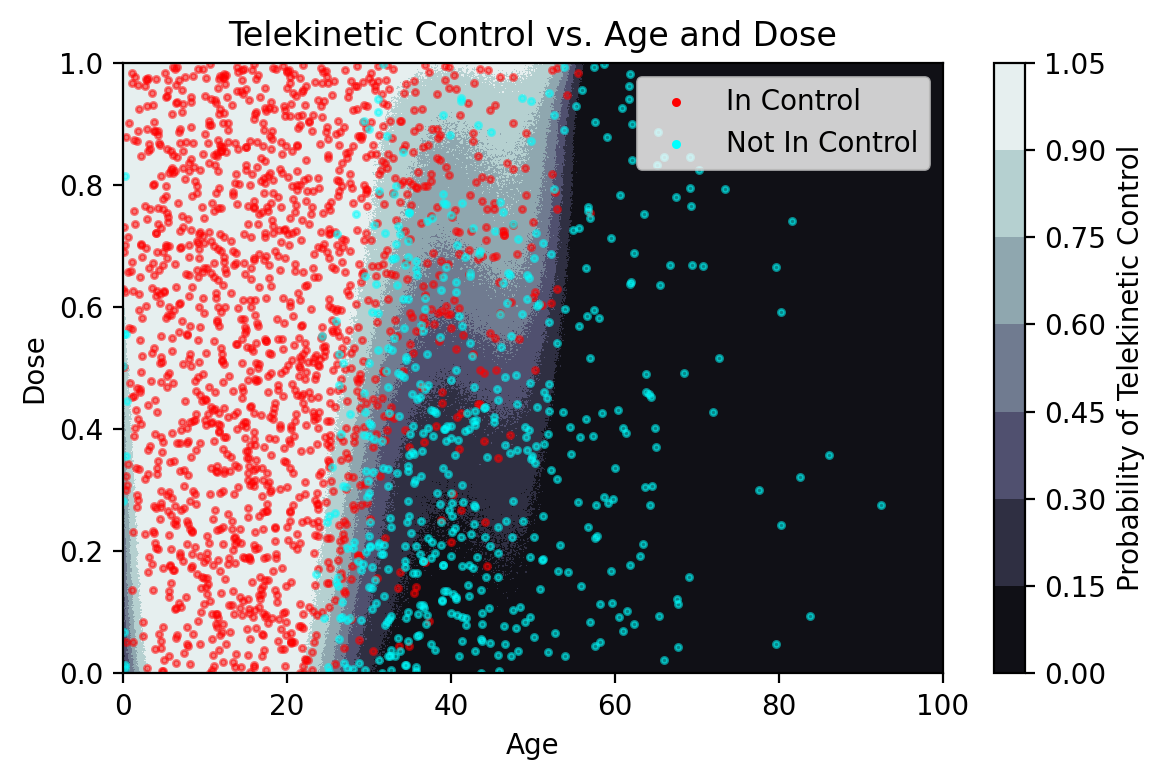

In [81]:
test_x1, test_x2 = jnp.meshgrid(
    jnp.linspace(0.0, 100.0, 1000),
    jnp.linspace(0.0, 1.0, 1000),
)

test_x = jnp.concatenate([test_x1.reshape(-1, 1), test_x2.reshape(-1, 1)], axis=-1)

S = 200
samples = cs349_sample_generative_process(
    result.model_mle, 
    jrandom.PRNGKey(seed=0), 
    len(test_x), 
    test_x,
    degree=DEGREE,
    num_samples=S,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

contour = ax.contourf(test_x1, test_x2, samples['y'].mean(axis=0).reshape(test_x1.shape), cmap=plt.cm.bone)

in_control = (data['Telekinetic-Control'] == 1)
ax.scatter(data['Age'][in_control], data['Dose'][in_control], alpha=0.5, s=5.0, c='red', label='In Control')
ax.scatter(data['Age'][~in_control], data['Dose'][~in_control], alpha=0.5, s=5.0, c='cyan', label='Not In Control')

ax.set_xlim(test_x1.min(), test_x1.max())
ax.set_ylim(test_x2.min(), test_x2.max())

ax.set_xlabel('Age')
ax.set_ylabel('Dose')
ax.set_title('Telekinetic Control vs. Age and Dose')
leg = ax.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1.0)

cbar = fig.colorbar(contour)
cbar.ax.set_ylabel('Probability of Telekinetic Control')

plt.tight_layout()
plt.show()